## Goal

    The goal is to build machine learning models that predicts user signup rate, and based on the models, to better understand what are the key features that have impact on submitting forms, and give sugguestions on how to improve user signup rate.



## Conclusion
    
    Model results show that active session time and actions related to visiting demo page(click for demo-link, url contains 'demo' keyword, visiting and closing demopage) are key factors that drive users to register('submit'). By looking at the conversion rate by segments, user segment with longer average session time and more demopage related visiting actions have high conversion rate, which is consistent with EDA and funnel analysis results in the previous analysis. Thus, the company should focus on improving users' session length and incentivizing users to click buttons and visit demo-page. 

## Modeling Summary

### EDA and Feature Processing

The 'user_level_data2' dataset is a pre-processed dataset from notebook 'Sensors_DataWrangling'. It's a flattened user level data with columns(frequecy count,unique count,time difference, binary indicator) aggregated from user log data. 

* Since some transformation steps have been done in the previous notebook, only few steps are taken to further prepare the dataset for model fitting. 
    1. regroup cols with too many levels into topN levels, and apply one-hot-encoding
    2. time-related variable have skewed distribution and large values, apply log transformation to them
    3. for features such as model,os, change the frequency count to binary flag 
    4. Since NA in most columns indicating no such event/properties, fill NA with 0


* Create 'convert' label to indicate if user has the intention to submit or not. By checking the correlation between events and overlap between events, users who had any event of 'formSubmit', 'clickSubmit', 'click_send_cellphone', 'verify_cellphone_code' are defined as convertors(users who have the intention to signup). The conversion rate is about 4.4%.



* Before getting into modeling part, some columns need to be dropped.
    1. columns will leak conversion information. 
        * Columns such as 'properties.company', 'properties.contact', 'properties.isSuccess' are unique properties generated by event 'forSubmit'/'clickSubmit'; 
        * Columns such as 'properties.name_request_request','properties.requestBtn' have mix information of submit and other events(btnclick);
        * Columns such as 'freq','event' contains count/unique_count of events defined as convert.
    2. Some time related columns have multiple representation(in diffrent units). To avoid high correlation, these cols can be dropped.



### Models and Performance

-  **Models**: Logistic Regression, Single Decision Tree and Bagged Decision Trees, Random Forest.


-  **Data**: 0.7/0.3 split for train and test. For train dataset,  4.3% data labelled as ‘1’; For test, 4.7% data is labelled as ‘1’. The positive label distribution in train and test are quite similar.  However, both datasets have imbalanced distribution of ‘1’ and ‘0’ label.  Upsampling(SMOTE) and Downsampling(random sampling) methods are tested to reduce the impact of imbalanced dataset. Also, parameter ‘classweight’ is adjusted to penalize the cost when giving wrong prediction of positive label. 


-  **Model Fitting**: Each Model is fitted with three different datasets: original, upsampled dataset and downsampled dataset. Also, hand-tuned parameter is tested in each category of models. 


-  **Metrics**: ROC and Precision-Recall Curve are plotted for each model.  For models with original dataset, all models provide good auc score and good upper-left ROC curve. However, it’s not meaningful in the case of imbalanced dataset because false positive rate will increase slowly(denominator is large) and thus make the ROC curve more likely to be at upper left position. In this case, we care more about the right classification of ‘1’ labels, thus  precision and recall will be a better metric to look at.


-  **Model Performance**:  Logistic Regression with L1 regularization have quite close performace to Random Forest in terms of AUC score and Accuracy. Random Forest have higher Recall score while logistic regression have higher precision score.

    * For Logistic Regression models, adding L1 regularization helps to reduce the effect of overfitting and improve the PR curve.  Upsampled data and downsampled data give great performance on train data but poor performance on test data, which is a sign of overfitting. Adjusting the classweight and standardizing features help to improve the PR curve slightly. 
    * For decision tree models(single decision tree and bagged decision tree):  For single decision tree models, both ROC and PR curve show clear sign of overfitting. By applying bagging to decision trees, it greatly improves precision and recall, and reduces the curve gap between train and test. 
    * For random forest models, by reducing the features number to 50 ( about half of original feature size) and setting classweight to ‘balanced’, the PR curve is slightly improved(reduced gap) compared to the default RF model with full set of features. 
    
|Model|AUC|Accuracy|Precision|Recall|f1-score|PR-AUC|
|--|--|--|--|--|--|--|
|LR1(with L1 regularization)|98.54%|97.96%|81.46%|73.65%|77.36%|0.8123|
|Decision Tree	|91.58%|	97.11%|	70.19%|	67.66%|	68.90%|	0.7081|
|Bagged Tree	|98%|	96.48%|	58.85%|	85.63%|69.23%|	0.78|
|Random Forest	|98.21%|	97.42%	|69.39%	|81.43%|	74.93%|	0.7790|


- **Important Variables**: 
    
    * ‘url_path_cat_demo’: the count of url_path contains keyword ‘demo’ 
    * ‘demo_leave’: The number of times that user closes demo page
    * ’page_demo’: the number of times that user is at demo page
    * ‘name_request_demo’: the number of times that user request for demo link 

    All these variables are indicating users active level of interaction with demo page. The higher number indicates that users are more interested in the demo content, which will lead users to register for demo(converted users). 

    ‘AvgSession_Time ‘ is the average length of a session per user, which shows the length of time that users have been actively interacting with website.


- **Conversion by Segment**:

    For the above 5 important variables, conversion rate improves as the number of demo related actions and average session increase. User group with no action of demo-related visits or average session time less than 1 minute have low conversion rate(less than 1%). 
    * Users group has at least 3 urls with demo keyword have conversion rate greater than 50%
    * User group with average session time between 1 and 10 minutes has conversion rate of 12.5%
    * User group with more than 1 ‘demo_leave’ event has conversion rate of 48%
    * User group with more than 1 ‘btnClick’ event has conversion rate of 17%.  With a further look at clicked button category, users who have clicked demo page button have conversion rate of 27%; And users who have clicked direct request for demo have conversion rate of 25%. 
    * Mobile user have much conversion rate than pc user.
    * Beijing and Guangdong users have conversion rate slightly above average.
    * Chrome and Firefox users have higher conversions rate than Safari and other browser users.

### Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# This statement allow to display plot without asking to
%matplotlib inline
# Always make it pretty.
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('data/user_level_data2.csv')
# properties.name needs to regenrate

In [3]:
df.head(10)

,distinct_id,freq,event,$pageview,about_leave,btnClick,clickSubmit,click_send_cellphone,courses_leave,courses_play_leave,...,properties.page_index,properties.pagePosition,pageStayTime_avg,pageStayTime_max,pageStayTime_min,properties.requestBtn,properties.result,properties.result_cat_correct,properties.result_cat_error,properties.verification_code
0,00007ef910b6c9911f1b89d01a09aa3fc862f4a9,7,5,1.0,NaN,1.0,NaN,2.0,NaN,NaN,...,1.0,0,NaN,NaN,NaN,1,3,2.0,1.0,1
1,000a216b72eff19bd0d5e17b9e676dd6ad9a38ac,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,921142.371000,921142.371,921142.371,0,0,0.0,0.0,0
2,000c46a27ef69fa22b56d253a9c72773338a1686,23,4,6.0,NaN,9.0,NaN,NaN,1.0,NaN,...,8.0,1,1742.216571,2598.906,2.224,1,0,0.0,0.0,0
3,000ed1dcd942969b458c5b308937c6389c08f999,5,3,2.0,NaN,1.0,NaN,NaN,NaN,NaN,...,1.0,1,30.680000,30.680,30.680,0,0,0.0,0.0,0
4,00111feff544ef5280a4c7064a362a9ea59c9389,2,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,NaN,NaN,0,0,0.0,0.0,0
5,0011f5066b1c62717255852fdb15a0473a5c2b19,7,3,3.0,NaN,2.0,NaN,NaN,NaN,NaN,...,1.0,1,4.170000,4.170,4.170,0,0,0.0,0.0,0
6,0012ea1b517e6959354abaa6954711054ec831b9,3,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1,35.747000,35.747,35.747,0,0,0.0,0.0,0
7,002232cd6da95fae1cc9a5fbaa7c2d0e11fbd57b,4,3,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,1.0,1,18.916000,18.916,18.916,1,0,0.0,0.0,0
8,00229f012ef316de6efdcbc380ffdb2558e9ff81,4,2,2.0,NaN,1.0,NaN,NaN,NaN,NaN,...,0.0,0,NaN,NaN,NaN,1,0,0.0,0.0,0
9,0023b8aa9adf510ef81d0e90e175d809f2bf6059,2,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0,NaN,NaN,NaN,0,0,0.0,0.0,0


In [4]:
df.shape[0],df.shape[1]

(11756, 121)

### Feature Processing

In [5]:
df.columns[df.dtypes=='O']

Index(['distinct_id', 'time_date_full_min', 'time_date_full_max',
       'properties.$browser_cat', 'properties.$first_browser_language0',
       'properties.$is_first_day', 'properties.$is_first_time', 'country',
       'province', 'properties.info', 'properties.company',
       'properties.contact', 'properties.email'],
      dtype='object')

In [6]:
# cols such as 'country'and 'province', have too many levels, only keeping the top categories
df['province'].value_counts(dropna=False).head(10)
# df['country'].value_counts(dropna=False)

Beijing      3945
Guangdong    2480
Shanghai     1388
Zhejiang     1003
Jiangsu       584
Sichuan       479
Hubei         275
NaN           266
Tianjin        97
Shandong       92
Name: province, dtype: int64

In [7]:
df['properties.$ip_Beijing'] = np.where(df['province']=='Beijing',1,0)
df['properties.$ip_Guangdong'] = np.where(df['province']=='Guangdong',1,0)
df['properties.$ip_Shanghai'] = np.where(df['province']=='Shanghai',1,0)
df['properties.$ip_Zhejiang'] = np.where(df['province']=='Zhejiang',1,0)
df['properties.$ip_China'] = np.where(df['country']=='China',1,0)

In [8]:
# the time variable is in unit of MS, large values, need to be transformed
log_cols = ['time_date_toNow_max','time_datefull_diffbyMS_min','time_datefull_diffbyMS_max'\
           ,'time_datefull_diffbyMS_mean','time_durationByMS',]

In [9]:
df[log_cols] = np.log(df[log_cols]+1)

In [10]:
to_binary = ['properties.$model_cat_mac','properties.$model_cat_other','properties.$model_cat_pc'\
             ,'properties.$os_cat_Android','properties.$os_cat_iOS', 'properties.$os_cat_linux'\
            ,'properties.$os_cat_macosx', 'properties.$os_cat_windows']

In [11]:
df[to_binary] = df[to_binary].apply(lambda x:np.where(x>0,1,0))

In [12]:
one_hot_encoding = ['properties.$browser_cat','properties.$first_browser_language0']

In [13]:
df_sub1 = pd.get_dummies(df[one_hot_encoding])
df = pd.concat([df,df_sub1],axis=1)

Checking correlation between formSubmit and other events, 'clickSubmit','verify_cellphone_code' and 'click_send_cellphone' have both relatively high correlation and high overlap. 

In [14]:
corr = df[['$pageview', 'about_leave','btnClick', 'clickSubmit', 'click_send_cellphone', 'courses_leave',\
           'courses_play_leave', 'demo_leave', 'formSubmit', 'index_leave','page_close', \
           'verify_cellphone_code']].corr()

In [15]:
corr['formSubmit'].sort_values()

page_close              -0.461538
courses_play_leave      -0.009186
btnClick                 0.022576
$pageview                0.025414
courses_leave            0.042716
demo_leave               0.052976
index_leave              0.076479
clickSubmit              0.125000
verify_cellphone_code    0.221859
click_send_cellphone     0.223743
about_leave              0.423329
formSubmit               1.000000
Name: formSubmit, dtype: float64

In [16]:
print('formSubmit',df[(df['formSubmit']>0)].index.nunique())
print ('clickSubmit & formSubmit',df[(df['clickSubmit']>0)&(df['formSubmit']>0)].index.nunique())
print ('send & submit', df[(df['formSubmit'] > 0) & (df['click_send_cellphone']>0)].index.nunique())
print ('verify & submit', df[(df['formSubmit'] > 0) & (df['verify_cellphone_code']>0)].index.nunique())
print('leave & submit',df[(df['about_leave']>0) & (df['formSubmit']>0)].index.nunique())

formSubmit 497
clickSubmit & formSubmit 457
send & submit 477
verify & submit 464
leave & submit 72


In [17]:
# create target variable; define users who have clickSubmit and formSubmit as convertors 
df['convert'] = np.where((df['formSubmit'] > 0) | (df['clickSubmit']>0) | (df['click_send_cellphone']>0) | (df['verify_cellphone_code']>0),1,0 )
#df['convert'] = np.where((df['formSubmit'] > 0) ,1,0 )

In [18]:
print(df['convert'].sum(),df['convert'].sum()/df.shape[0])

521 0.044317795168424635


### Drop cols 

In [21]:
# the following cols has properties triggered by 'submit' or 'send/verify cellphone'
drop_cols = ['freq','event','clickSubmit','click_send_cellphone','formSubmit','verify_cellphone_code'\
             ,'time_date_full_min','time_date_full_max','time_datefull_diffByMinute_max','time_datefull_diffByMinute_mean'\
            ,'time_datefull_diffByMinute_min','properties.$is_first_day','properties.info','properties.company','properties.name'\
             , 'properties.contact', 'properties.email','properties.isMsg', 'properties.isSuccess','properties.result'\
            ,'properties.result_cat_correct', 'properties.result_cat_error','properties.verification_code','country','province'\
             ,'properties.name_request_request','properties.requestBtn'
            ]

In [22]:
df.drop(drop_cols,inplace=True,axis=1)

In [23]:
df.drop(one_hot_encoding,inplace=True,axis=1)

In [24]:
df.drop('distinct_id',inplace=True,axis=1)

In [25]:
df.drop('screen',inplace=True,axis=1)
#df_features['screen'] = np.log(df_features['screen']+1,)

In [26]:
df['properties.$is_first_time'] = df['properties.$is_first_time'].astype(float)

In [27]:
#df_features.columns.values
#smry1 = df_features.describe()
#df_features.describe().info()
df.fillna(0,inplace=True)

In [28]:
selected_features = df.columns.difference(['convert'])

In [29]:
df.groupby('properties.$is_first_time')['convert'].value_counts(dropna=False)

properties.$is_first_time  convert
0.0                        0          2335
                           1            84
1.0                        0          8900
                           1           437
Name: convert, dtype: int64

### Train and Test Split

In [30]:
X = df[selected_features].values
y = df['convert'].values

In [31]:
# import train test split function from sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [32]:
# checking pos label in test set
y_test.sum()/len(y_test)

0.047349021831584917

In [33]:
#checking pos label in train set
y_train.sum()/len(y_train)

0.04301859278162596

### Oversampling Train dataset

In [34]:
from imblearn.over_sampling import SMOTE

In [35]:
sm = SMOTE(random_state=0, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/Users/qingfenghu/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [36]:
# showing upsampled label distribution
from collections import Counter
sorted(Counter(y_train_res).items())
#sorted(Counter(y_train).items())

[(0, 7875), (1, 7875)]

### Undersampling Test dataset

In [37]:
from imblearn.under_sampling import RandomUnderSampler

In [38]:
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

In [39]:
# showing downsampled label distribution
sorted(Counter(y_train_rus).items())

[(0, 354), (1, 354)]

### Helper Function to calculate and plot the metric for the model

In [40]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

In [41]:
import pandas as pd
# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.utils.fixes import signature

def plot_precision_recall(y_train, p_train_pred, y_test, p_test_pred):
    precision_train, recall_train, _ = precision_recall_curve(y_train, p_train_pred)
    auc_train = auc(recall_train,precision_train)
    
    precision_test, recall_test, _ = precision_recall_curve(y_test, p_test_pred)
    auc_test = auc(recall_test,precision_test)
    
    plt.figure()
    
    lw = 2
    plt.plot(recall_train, precision_train, color='green',
             lw=lw, label='PR Train (AUC = %0.4f)' % auc_train)
    plt.plot(recall_test, precision_test, color='darkorange',
             lw=lw, label='PR Test (AUC = %0.4f)' % auc_test)
    #plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower left")
    plt.show()
    

In [44]:
# define function to perform train, test, and get model performance
#from sklearn.metrics import classification_report

def train_test_model(clf, X_train, y_train, X_test, y_test):
    # Fit a model by providing X and y from training set
    clf.fit(X_train, y_train)

    # Make prediction on the training data
    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    # Make predictions on test data
    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    # print model results
    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)
    plot_precision_recall(y_train, p_train_pred, y_test, p_test_pred)
    #print(classification_report(y_test,y_test_pred))

### Logistic Regression

Fitting three LR models(L2/L1/L1+ classweight=‘balanced’) with original data/upsampled data/downsampled data.
From the ROC and PR curve, we can see that 

1. All models have high AUC and good ROC curve on both train and test dataset; but PR curve has relatively low performance, especially on test dataset.
2. For upsampled data and down sampled data, there are huge gaps between test PR curve and training PR curve, which is indicating that the model is overfitting the dataset in both cases. Either synthetic samples or reduced samples doesn’t help to improve the performance of model.
3. Adding L1 regularization helps to reduce the effect of overfitting and achieves optimal in both AUC and PR curve performance.
4. In LR models with L2 regularization, using ’classweight=‘balanced’’ helps to improve the PR curve, but not as significant as changing ‘L2’ to ‘L1’.

In [41]:
# Import logistic regression from sklearn
from sklearn.linear_model import LogisticRegression

# Initialize model by providing parameters
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf_lr = LogisticRegression(C=1.0, penalty='l2')
clf_lr1 = LogisticRegression(C=1.0, penalty='l1')
clf_lr2 = LogisticRegression(C=1.0, penalty='l1',class_weight='balanced')
clf_lr3 = LogisticRegression(C=1.0, penalty='l2',class_weight='balanced')

In [57]:
from sklearn.preprocessing import StandardScaler

# To be implemented
scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)

              train      test
metrics                      
AUC        0.989582  0.966825
Accuracy   0.983595  0.970230
Precision  0.873720  0.746032
Recall     0.723164  0.562874
f1-score   0.791345  0.641638


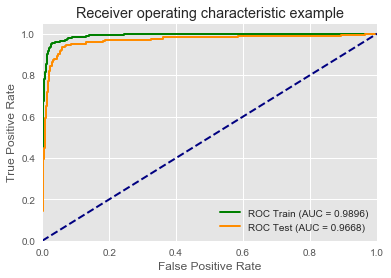

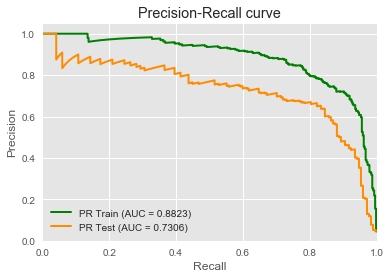

In [43]:
train_test_model(clf_lr, X_scaled_train, y_train, X_scaled_test, y_test)

              train      test
metrics                      
AUC        0.956854  0.944493
Accuracy   0.970349  0.957471
Precision  0.812500  0.602410
Recall     0.403955  0.299401
f1-score   0.539623  0.400000


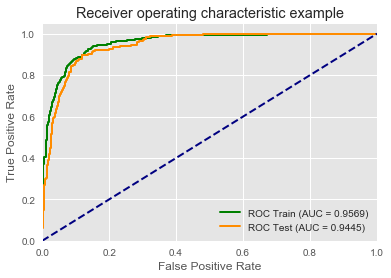

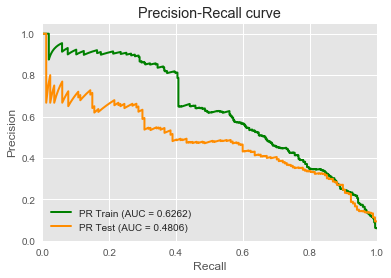

In [44]:
#this result is used as benchmark to compare with other models
train_test_model(clf_lr, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.985255  0.972842
Accuracy   0.942399  0.937057
Precision  0.424433  0.423398
Recall     0.951977  0.910180
f1-score   0.587108  0.577947


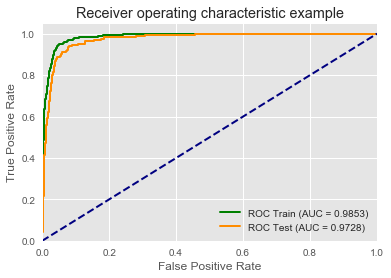

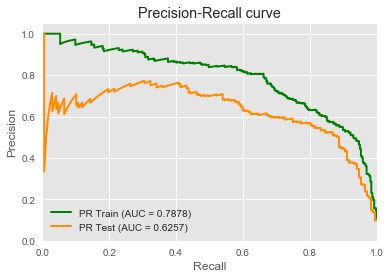

In [45]:
train_test_model(clf_lr3, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.986515  0.970908
Accuracy   0.950540  0.939892
Precision  0.946739  0.434402
Recall     0.954794  0.892216
f1-score   0.950749  0.584314


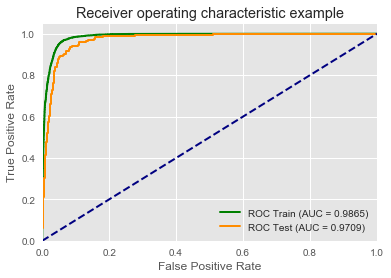

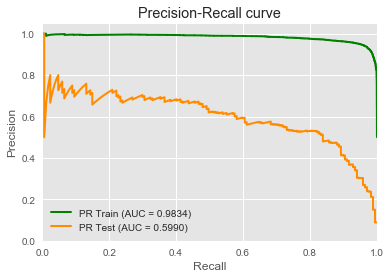

In [46]:
# result with oversampling
train_test_model(clf_lr, X_train_res, y_train_res, X_test, y_test)

              train      test
metrics                      
AUC        0.993129  0.970655
Accuracy   0.959040  0.929118
Precision  0.962963  0.393862
Recall     0.954802  0.922156
f1-score   0.958865  0.551971


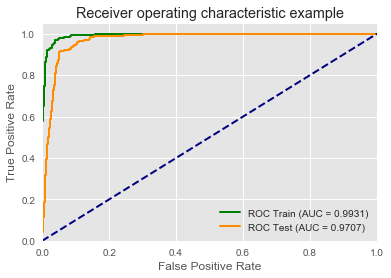

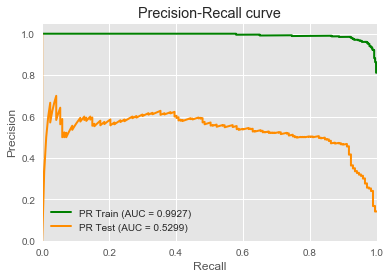

In [47]:
train_test_model(clf_lr, X_train_rus, y_train_rus, X_test, y_test)

              train      test
metrics                      
AUC        0.993205  0.985370
Accuracy   0.985782  0.979586
Precision  0.883495  0.814570
Recall     0.771186  0.736527
f1-score   0.823529  0.773585


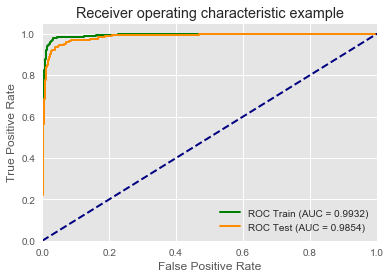

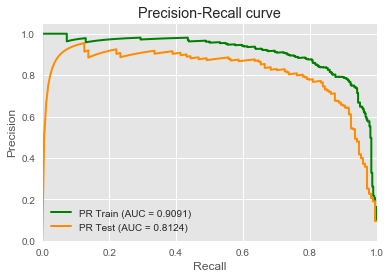

In [48]:
train_test_model(clf_lr1, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.993511  0.980731
Accuracy   0.984081  0.974199
Precision  0.865574  0.787879
Recall     0.745763  0.622754
f1-score   0.801214  0.695652


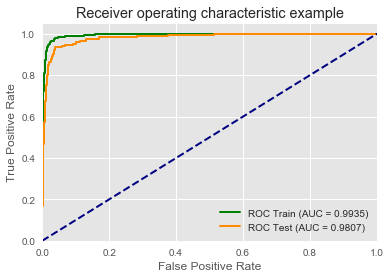

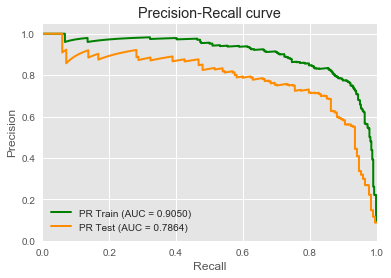

In [49]:
train_test_model(clf_lr1, X_scaled_train, y_train, X_scaled_test, y_test)

              train      test
metrics                      
AUC        0.995812  0.977037
Accuracy   0.980952  0.965693
Precision  0.972198  0.588462
Recall     0.990222  0.916168
f1-score   0.981127  0.716628


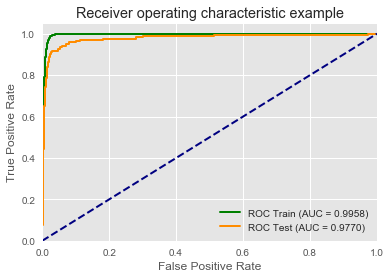

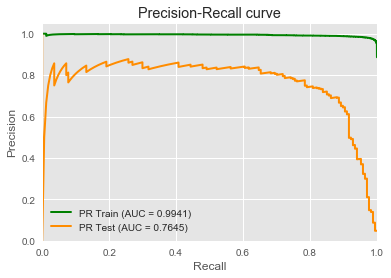

In [50]:
train_test_model(clf_lr1, X_train_res, y_train_res, X_test, y_test)

              train      test
metrics                      
AUC        0.994765  0.976937
Accuracy   0.967514  0.935639
Precision  0.966197  0.419786
Recall     0.968927  0.940120
f1-score   0.967560  0.580407


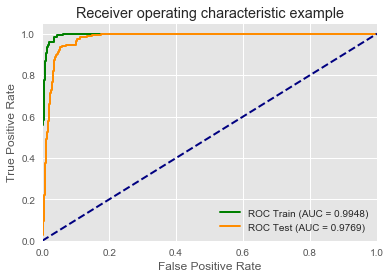

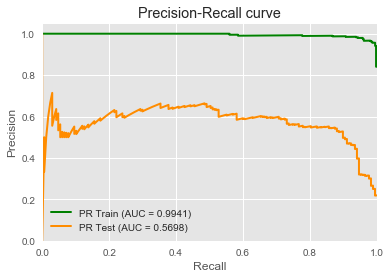

In [51]:
train_test_model(clf_lr1, X_train_rus, y_train_rus, X_test, y_test)

              train      test
metrics                      
AUC        0.994873  0.982692
Accuracy   0.968647  0.960306
Precision  0.579470  0.548387
Recall     0.988701  0.916168
f1-score   0.730689  0.686099


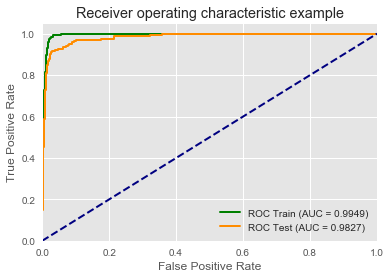

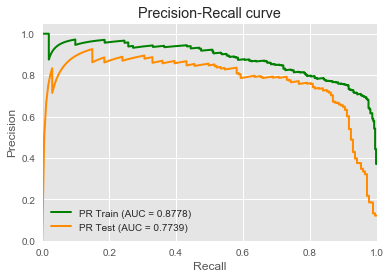

In [52]:
train_test_model(clf_lr2, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.995873  0.978099
Accuracy   0.981079  0.965126
Precision  0.972440  0.584615
Recall     0.990222  0.910180
f1-score   0.981251  0.711944


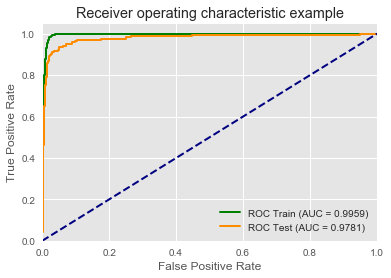

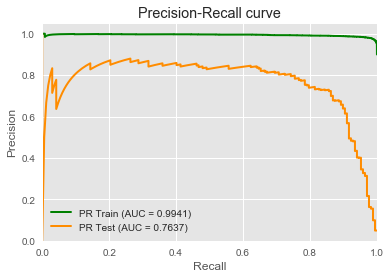

In [53]:
train_test_model(clf_lr2, X_train_res, y_train_res, X_test, y_test)

              train      test
metrics                      
AUC        0.994845  0.977048
Accuracy   0.968927  0.936206
Precision  0.966292  0.422043
Recall     0.971751  0.940120
f1-score   0.969014  0.582560


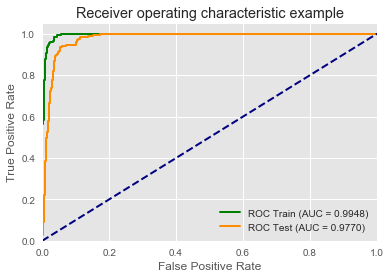

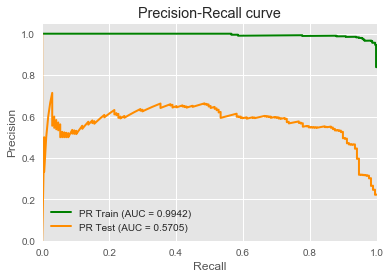

In [54]:
train_test_model(clf_lr2, X_train_rus, y_train_rus, X_test, y_test)

In [55]:
df_coeffs = pd.DataFrame(list(zip(selected_features, clf_lr1.coef_.flatten()))).sort_values(by=[1], ascending=False)
df_coeffs.columns = ['feature', 'coeff']
df_coeffs

,feature,coeff
101,time_durationByMS,2.969337
75,properties.$url_path_cat_demo,1.343857
65,properties.$os_cat_iOS,1.173601
4,btnClick,0.751274
27,properties.$first_browser_language0_zh,0.600438
21,properties.$browser_cat_chrome,0.434983
89,properties.page,0.406453
53,properties.$latest_utm_medium_cat_mcpc,0.299002
77,properties.$url_path_cat_other,0.245690
50,properties.$latest_utm_content_cat_通用,0.233372


In [56]:
top10_pos = df_coeffs.reset_index().iloc[:10,]

In [57]:
top10_pos.drop('index',inplace=True,axis=1)

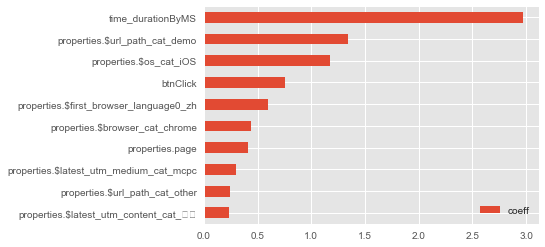

In [58]:
#showing top10 positive features
ax = top10_pos.plot.barh()
t = np.arange(10)
ax.set_yticks(t)
ax.set_yticklabels(df_coeffs['feature'])
ax.invert_yaxis()
plt.show()

In [59]:
neg_index = np.arange(-1,-10,-1)
top10_neg = df_coeffs.reset_index().iloc[neg_index,]

In [60]:
top10_neg.drop('index',inplace=True,axis=1)

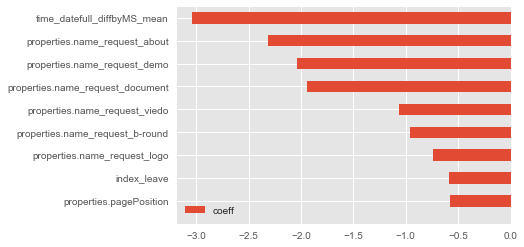

In [61]:
#showing top10 negative features
ax = top10_neg.plot.barh()
t = np.arange(10)
ax.set_yticks(t)
ax.set_yticklabels(top10_neg['feature'])
ax.invert_yaxis()
plt.show()

### Single Decision Tree
Among four decision tree models, both ROC and PR curve are showing overfitting trend, especially on upsampled dataset and downsampled dataset. The performance on testing dataset is even worse than the benchmark model.

In [62]:
from sklearn.tree import DecisionTreeClassifier
clf_stree = DecisionTreeClassifier(max_depth=20,min_samples_leaf=10)
clf_stree2 = DecisionTreeClassifier(max_depth=30,min_samples_leaf=10)
clf_stree3 = DecisionTreeClassifier(max_depth=20,min_samples_leaf=10,class_weight='balanced')
clf_stree4 = DecisionTreeClassifier(max_depth=20,min_samples_leaf=10,class_weight={0:1,1:5})

              train      test
metrics                      
AUC        0.995957  0.924673
Accuracy   0.985053  0.971080
Precision  0.864353  0.701863
Recall     0.774011  0.676647
f1-score   0.816692  0.689024


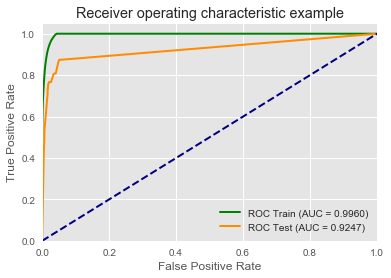

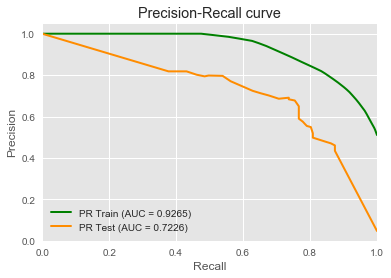

In [63]:
# Train test model
train_test_model(clf_stree, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.995902  0.915718
Accuracy   0.985053  0.971364
Precision  0.864353  0.703704
Recall     0.774011  0.682635
f1-score   0.816692  0.693009


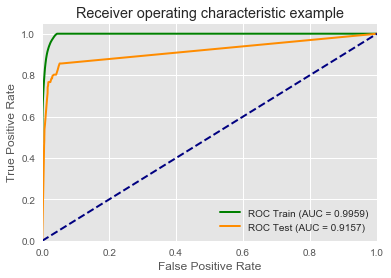

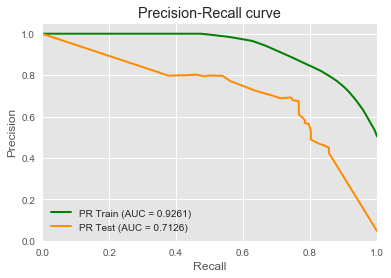

In [64]:
train_test_model(clf_stree2, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.997098  0.892032
Accuracy   0.967797  0.945279
Precision  0.571890  0.455782
Recall     1.000000  0.802395
f1-score   0.727646  0.581345


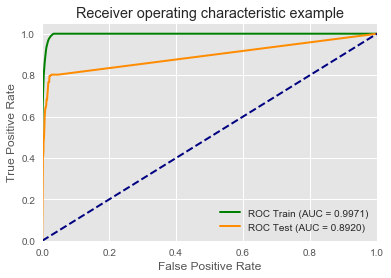

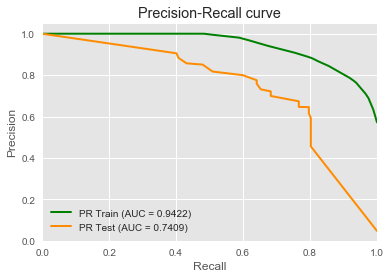

In [65]:
train_test_model(clf_stree3, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.996335  0.911267
Accuracy   0.974602  0.957471
Precision  0.633517  0.532567
Recall     0.971751  0.832335
f1-score   0.767001  0.649533


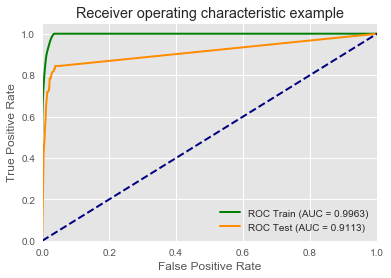

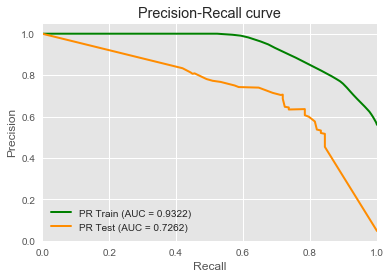

In [66]:
train_test_model(clf_stree4, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.998908  0.922756
Accuracy   0.984000  0.956053
Precision  0.970497  0.521739
Recall     0.998349  0.862275
f1-score   0.984226  0.650113


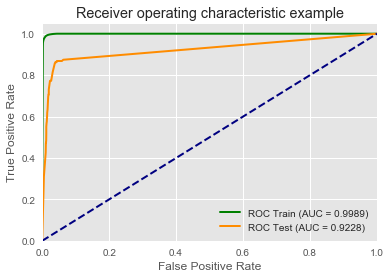

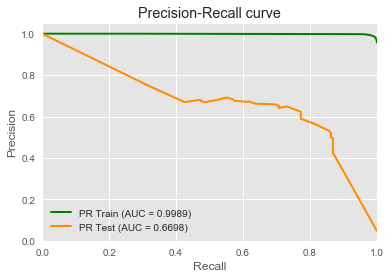

In [67]:
train_test_model(clf_stree4, X_train_res, y_train_res, X_test, y_test)

              train      test
metrics                      
AUC        0.992036  0.940601
Accuracy   0.923729  0.838957
Precision  0.871287  0.221914
Recall     0.994350  0.958084
f1-score   0.928760  0.360360


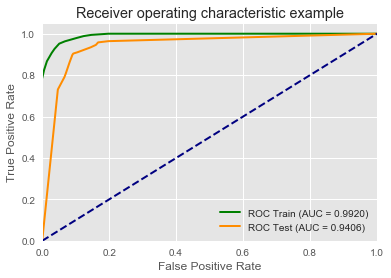

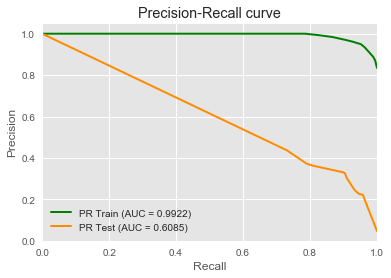

In [68]:
train_test_model(clf_stree4, X_train_rus, y_train_rus, X_test, y_test)

### Bagged Tree

Bagged decision trees reduced overfitting issue in single decision tree by increasing the number of estimators. Still, the performance on upsampled dataset and downsampled dataset is bad, and also upsampled dataset increase the  training time for models. 

In [69]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html 
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_classifier = DecisionTreeClassifier(max_depth=20,min_samples_leaf=10,class_weight='balanced')
# Choose some parameter combinations to try
parameters = {
              'base_estimator':base_classifier,
              'n_estimators': 50,
              'n_jobs': -1
              }

clf_btree = BaggingClassifier(**parameters)

In [70]:
parameters1 = {
              'base_estimator':base_classifier,
              'n_estimators': 100,
              'n_jobs': -1
              }

clf_btree1 = BaggingClassifier(**parameters1)

              train      test
metrics                      
AUC        0.997065  0.978625
Accuracy   0.980557  0.965410
Precision  0.691700  0.594142
Recall     0.988701  0.850299
f1-score   0.813953  0.699507


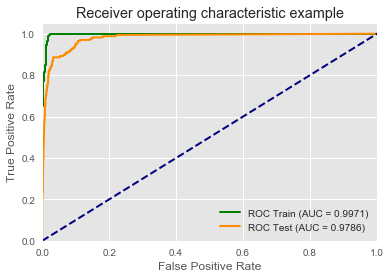

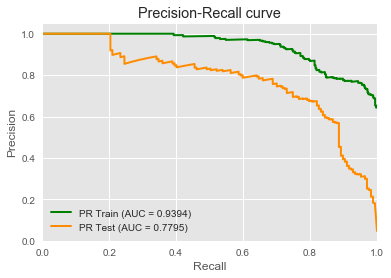

In [71]:
# Train test model
train_test_model(clf_btree, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.997045  0.975069
Accuracy   0.980070  0.964559
Precision  0.686275  0.586777
Recall     0.988701  0.850299
f1-score   0.810185  0.694377


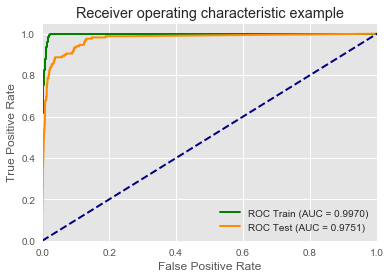

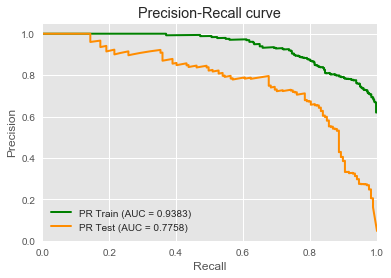

In [72]:
# Train test model
train_test_model(clf_btree1, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.999602  0.973351
Accuracy   0.988317  0.967961
Precision  0.985482  0.633663
Recall     0.991238  0.766467
f1-score   0.988351  0.693767


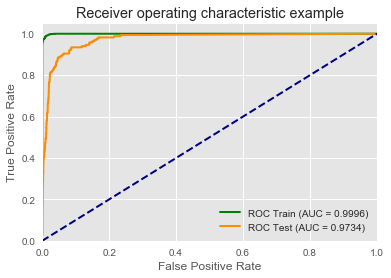

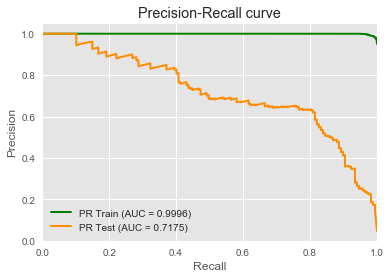

In [73]:
# Train test model
train_test_model(clf_btree1, X_train_res, y_train_res, X_test, y_test)

              train      test
metrics                      
AUC        0.992084  0.967433
Accuracy   0.942090  0.919478
Precision  0.928767  0.361045
Recall     0.957627  0.910180
f1-score   0.942976  0.517007


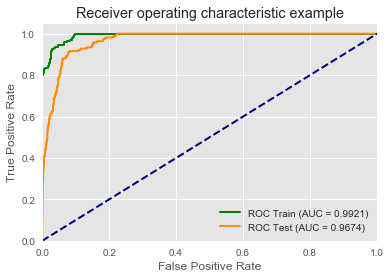

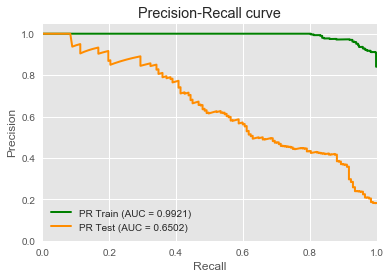

In [74]:
train_test_model(clf_btree1, X_train_rus, y_train_rus, X_test, y_test)

### Random Forest

All RF models helps to improve the PR curve and reduce the gap between train and test dataset(best performance among three cateogries). By reducing the number of features in the RF, the gap between train PR curve and test PR curve is also reduced. Adjusting the classweight doesn’t help much to improve the performance.


In [45]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.ensemble import RandomForestClassifier

# Choose some parameter combinations to try
parameters = {'n_estimators': 50,
             # 'max_features': 'auto',
             # 'criterion': 'gini',
              'max_depth': 20,
             # 'min_samples_split': 2,
              'min_samples_leaf': 10,
              'random_state': 0,
              'n_jobs': -1
              }

clf_rf = RandomForestClassifier(**parameters)


In [46]:

parameters1 = {'n_estimators': 100,
             # 'max_features': 'auto',
             # 'criterion': 'gini',
              'max_depth': 20,
             # 'min_samples_split': 2,
              'min_samples_leaf': 10,
              'random_state': 0,
              'n_jobs': -1
              }

clf_rf1 = RandomForestClassifier(**parameters1)

In [47]:
# Choose some parameter combinations to try
parameters2 = {'n_estimators': 100,
              'max_features': 50,
             # 'criterion': 'gini',
              'max_depth': 20,
             # 'min_samples_split': 2,
              'min_samples_leaf': 10,
              'random_state': 0,
              'n_jobs': -1
              }

clf_rf2 = RandomForestClassifier(**parameters2)

In [48]:
# Choose some parameter combinations to try
parameters3 = {'n_estimators': 100,
              'max_features': 50,
               'class_weight':{0:1,1:5},
             # 'criterion': 'gini',
              'max_depth': 20,
             # 'min_samples_split': 2,
              'min_samples_leaf': 10,
              'random_state': 0,
              'n_jobs': -1
              }

clf_rf3 = RandomForestClassifier(**parameters3)

In [49]:
# Choose some parameter combinations to try
parameters4 = {'n_estimators': 100,
              'max_features': 50,
               'class_weight':'balanced',
             # 'criterion': 'gini',
              'max_depth': 20,
             # 'min_samples_split': 2,
              'min_samples_leaf': 10,
              'random_state': 0,
              'n_jobs': -1
              }

clf_rf4 = RandomForestClassifier(**parameters4)

              train      test
metrics                      
AUC        0.994361  0.975256
Accuracy   0.982865  0.967678
Precision  0.914397  0.726496
Recall     0.663842  0.508982
f1-score   0.769231  0.598592


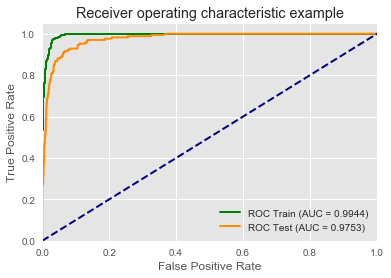

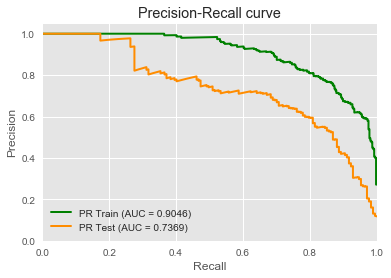

In [50]:
# Train test model
train_test_model(clf_rf, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.994486  0.976877
Accuracy   0.982501  0.967678
Precision  0.916667  0.738739
Recall     0.652542  0.491018
f1-score   0.762376  0.589928


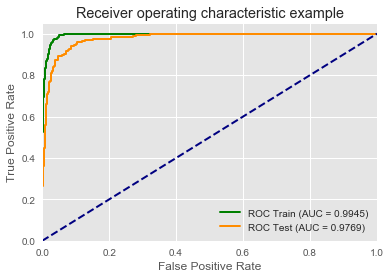

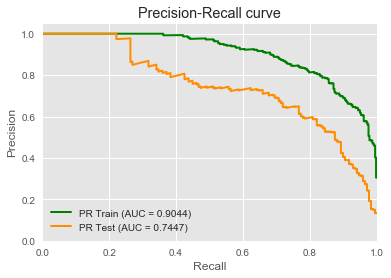

In [51]:
train_test_model(clf_rf1, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.996254  0.979567
Accuracy   0.985660  0.970797
Precision  0.909722  0.750000
Recall     0.740113  0.574850
f1-score   0.816199  0.650847


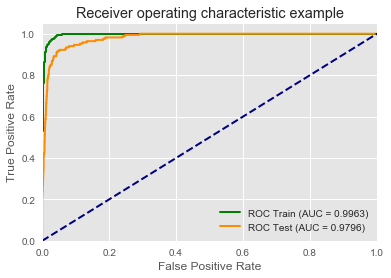

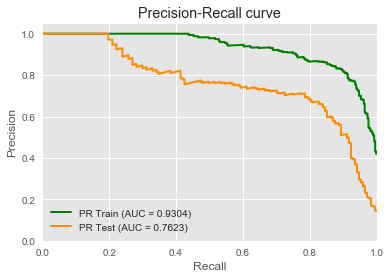

In [52]:
train_test_model(clf_rf2, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.997109  0.982093
Accuracy   0.987726  0.974199
Precision  0.807786  0.693878
Recall     0.937853  0.814371
f1-score   0.867974  0.749311


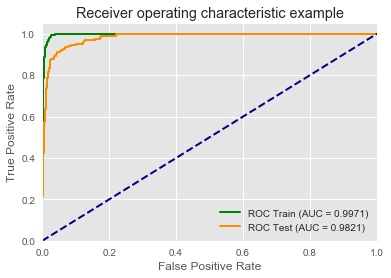

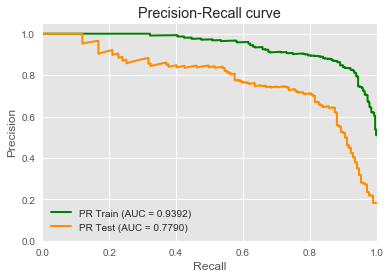

In [53]:
train_test_model(clf_rf3, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.997013  0.981835
Accuracy   0.978491  0.963709
Precision  0.667297  0.578947
Recall     0.997175  0.856287
f1-score   0.799547  0.690821


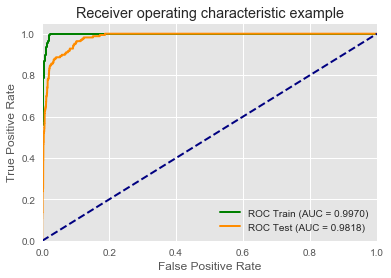

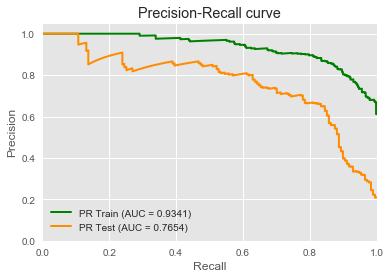

In [54]:
train_test_model(clf_rf4, X_train, y_train, X_test, y_test)

              train      test
metrics                      
AUC        0.996255  0.975307
Accuracy   0.985539  0.969379
Precision  0.909408  0.752137
Recall     0.737288  0.526946
f1-score   0.814353  0.619718


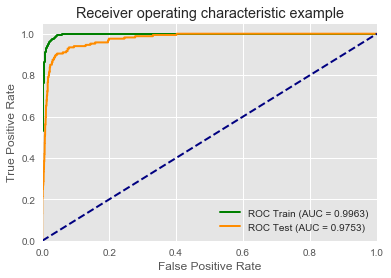

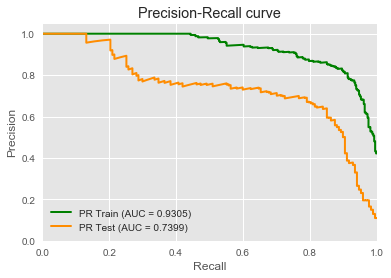

In [58]:
train_test_model(clf_rf2, X_scaled_train, y_train, X_scaled_test, y_test)

              train      test
metrics                      
AUC        0.999690  0.977863
Accuracy   0.989524  0.969096
Precision  0.986374  0.645000
Recall     0.992762  0.772455
f1-score   0.989558  0.702997


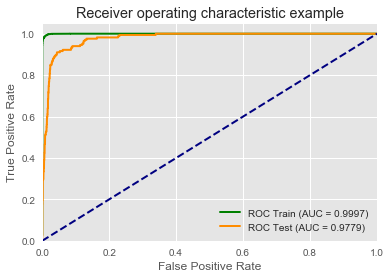

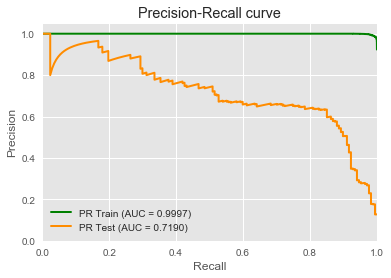

In [59]:
train_test_model(clf_rf2, X_train_res, y_train_res, X_test, y_test)

              train      test
metrics                      
AUC        0.992315  0.966626
Accuracy   0.944915  0.920612
Precision  0.936288  0.365155
Recall     0.954802  0.916168
f1-score   0.945455  0.522184


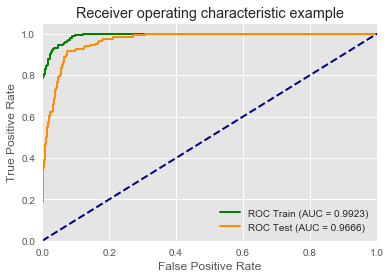

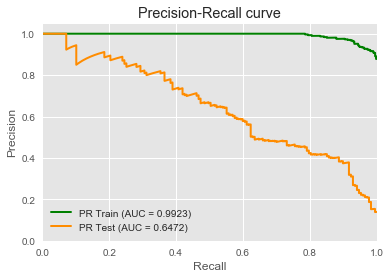

In [60]:
train_test_model(clf_rf2, X_train_rus, y_train_rus, X_test, y_test)

In [61]:
clf_rf3

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 5},
            criterion='gini', max_depth=20, max_features=50,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [62]:
importances = clf_rf3.feature_importances_
indices = np.argsort(importances)[::-1]

In [64]:
# Print the top20 feature ranking
print("Feature ranking:")
for f in range(20):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],selected_features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 75 properties.$url_path_cat_demo (0.331239)
2. feature 8 demo_leave (0.187854)
3. feature 1 AvgSessionTime_perUser (0.068078)
4. feature 93 properties.page_demo (0.057240)
5. feature 83 properties.name_request_demo (0.055141)
6. feature 59 properties.$latest_utm_source_cat_search (0.033487)
7. feature 50 properties.$latest_utm_content_cat_通用 (0.032403)
8. feature 19 prop_session_referrer_host_cat_search (0.027431)
9. feature 94 properties.page_index (0.018229)
10. feature 72 properties.$referrer_host_cat_sensors (0.016779)
11. feature 0 $pageview (0.015860)
12. feature 4 btnClick (0.013093)
13. feature 99 time_datefull_diffbyMS_mean (0.012259)
14. feature 100 time_datefull_diffbyMS_min (0.010316)
15. feature 15 pageStayTime_min (0.009600)
16. feature 79 properties.name_request (0.008780)
17. feature 101 time_durationByMS (0.008419)
18. feature 98 time_datefull_diffbyMS_max (0.007135)
19. feature 14 pageStayTime_max (0.006699)
20. feature 41 properties.$lates

### Conversion By Segment based on model result

‘url_path_cat_demo’: the count of url_path contains keyword ‘demo’ 
‘demo_leave’: The number of times that user closes demo page
’page_demo’: the number of times that user is at demo page
‘name_request_demo’: the number of times that user request for demo link 

All these variables are indicating users active level of interaction with demo page. The higher number indicates that users are more interested in the demo content, which will lead users to register for demo(converted users). 

‘AvgSession_Time ‘ is the average length of a session per user, which shows the length of time that users have been actively interact with website.


####  url_path_cat_demo: number of url_path contains keyword demo

In [100]:
df_urlpath = df[['properties.$url_path_cat_demo','convert']].copy()
df_urlpath['path_cat_demo_cat'] = df_urlpath['properties.$url_path_cat_demo']
df_urlpath.loc[df_urlpath['properties.$url_path_cat_demo']>=10,'path_cat_demo_cat']=10

In [107]:
request_cvt = df_urlpath.groupby('path_cat_demo_cat')['convert'].value_counts()
temp_res = request_cvt.unstack().fillna(0)
temp_res.columns = ['nonconv','conv']
url_path= temp_res['conv']/df_urlpath['path_cat_demo_cat'].value_counts()
url_path

0.0     0.005210
1.0     0.106426
2.0     0.338608
3.0     0.511450
4.0     0.520408
5.0     0.483871
6.0     0.608696
7.0     0.666667
8.0     0.650000
9.0     0.714286
10.0    0.589744
dtype: float64

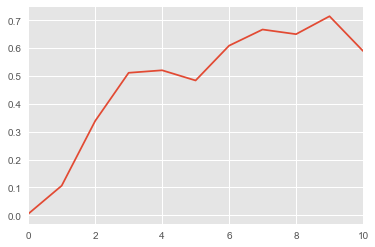

In [108]:
url_path.plot()

#### AvgSessionTime_perUser: average session per user

In [109]:
df['AvgSessionTime_perUser'].describe()

count    11756.000000
mean         2.607198
std          6.282565
min          0.000000
25%          0.000000
50%          0.152867
75%          1.546071
max         90.387000
Name: AvgSessionTime_perUser, dtype: float64

In [110]:
avg_peruser = df[['AvgSessionTime_perUser','convert']].copy()

In [111]:
avg_peruser_df = pd.DataFrame(avg_peruser)

In [112]:
avg_peruser['avg_cat'] = avg_peruser['AvgSessionTime_perUser']
avg_peruser.loc[avg_peruser['AvgSessionTime_perUser']<=0.1,'avg_cat'] = 'A1'
avg_peruser.loc[(avg_peruser['AvgSessionTime_perUser']>0.1) & (avg_peruser['AvgSessionTime_perUser']<=1),'avg_cat'] = 'A2'
avg_peruser.loc[(avg_peruser['AvgSessionTime_perUser']>1) & (avg_peruser['AvgSessionTime_perUser']<=10),'avg_cat'] = 'A3'
#avg_peruser.loc[(avg_peruser['AvgSessionTime_perUser']>2) & (avg_peruser['AvgSessionTime_perUser']<=10),'avg_cat'] = 'A4'
avg_peruser.loc[(avg_peruser['AvgSessionTime_perUser']>10) ,'avg_cat'] = 'A4'
#avg_peruser.loc[avg_peruser['AvgSessionTime_perUser']>50,'avg_cat'] = 'A6'

In [113]:
avg_peruser_res = avg_peruser.groupby('avg_cat')['convert'].value_counts().unstack()
avg_peruser_res.columns = ['nonconv','conv']

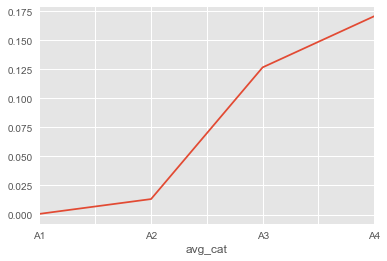

In [114]:
(avg_peruser_res['conv']/(avg_peruser['avg_cat'].value_counts())).plot()

#### demo_leave: the frequency of 'demo_leave' event  per user

In [115]:
demo_leaveuser = pd.DataFrame(df[['demo_leave','convert']].copy())

In [116]:
demo_leaveuser['demo_leave_cat'] = demo_leaveuser['demo_leave']
demo_leaveuser.loc[demo_leaveuser['demo_leave']==0,'demo_leave_cat'] = 'A:0'
demo_leaveuser.loc[demo_leaveuser['demo_leave']==1,'demo_leave_cat'] = 'A:1'
demo_leaveuser.loc[demo_leaveuser['demo_leave']>1,'demo_leave_cat'] = 'A:2'

In [117]:
df_demo_res = demo_leaveuser.groupby('demo_leave_cat')['convert'].value_counts().unstack()
df_demo_res.columns = ['nonconv','conv']

In [118]:
df_demo_res['conv'] / (demo_leaveuser['demo_leave_cat'].value_counts())

demo_leave_cat
A:0    0.010368
A:1    0.124359
A:2    0.483232
dtype: float64

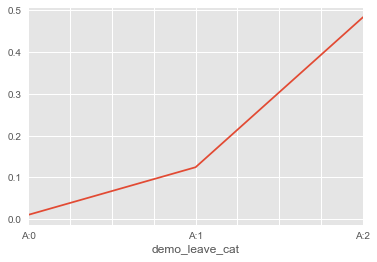

In [119]:
(df_demo_res['conv'] / (demo_leaveuser['demo_leave_cat'].value_counts())).plot()

#### btnClick User: the frequency of 'btnClick' event  per user

In [120]:
btnClickuser = pd.DataFrame(df[['btnClick','convert']].copy())

In [121]:
btnClickuser['btnClick_cat'] = btnClickuser['btnClick']
btnClickuser.loc[btnClickuser['btnClick']==0,'btnClick_cat'] = 'A:0'
btnClickuser.loc[btnClickuser['btnClick']==1,'btnClick_cat'] = 'A:1'
btnClickuser.loc[btnClickuser['btnClick']>1,'btnClick_cat'] = 'A:2'

In [122]:
df_btn_res = btnClickuser.groupby('btnClick_cat')['convert'].value_counts().unstack().fillna(0)
df_btn_res.columns = ['nonconv','conv']

In [123]:
df_btn_res['conv'] / (btnClickuser['btnClick_cat'].value_counts())

A:0    0.000000
A:1    0.042640
A:2    0.172659
dtype: float64

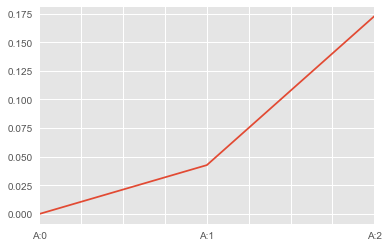

In [124]:
(df_btn_res['conv'] / (btnClickuser['btnClick_cat'].value_counts())).plot()

In [49]:
# further checking what button click have the highest conversion rate
btn_cols = ['properties.name_request_about', 'properties.name_request_b-round',
       'properties.name_request_blog', 'properties.name_request_demo',
       'properties.name_request_document', 'properties.name_request_logo',
       'properties.name_request_mail', 'properties.name_request_product',
       'properties.name_request_request', 'properties.name_request_viedo']
result = pd.DataFrame()
for col in btn_cols:
    conv_doc = df[(df[col]>=1)].groupby('convert').size()
    temp = conv_doc.divide(conv_doc.sum(),axis=0)
    temp.name = col
    result = pd.concat([result,temp],axis=1)

result.iloc[1,]

properties.name_request_about       0.110315
properties.name_request_b-round     0.130753
properties.name_request_blog        0.109325
properties.name_request_demo        0.272082
properties.name_request_document    0.083450
properties.name_request_logo        0.113772
properties.name_request_mail        0.081081
properties.name_request_product     0.106137
properties.name_request_request     0.247388
properties.name_request_viedo       0.096774
Name: 1, dtype: float64

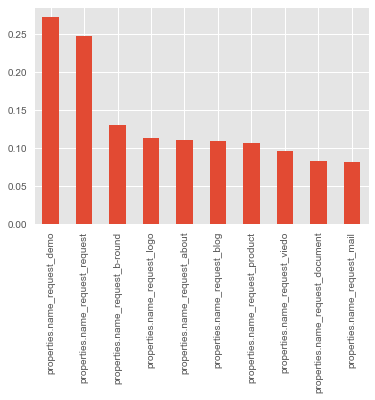

In [60]:
result.iloc[1,].sort_values(ascending=False).plot(kind='bar')

In [61]:
# checking users' conversion who had button clicks with direct request for demo and demo link
conv_both = df[(df['properties.name_request_demo']>=1) & (df['properties.name_request_request']>=1)].groupby('convert').size()
conv_both.divide(conv_both.sum(),axis=0)

convert
0    0.54
1    0.46
dtype: float64

#### page_demo: the frequency of page url  as demo page 

In [142]:
pagedemo = pd.DataFrame(df[['properties.page_demo','convert']].copy())
pagedemo['page_demo_cat'] = pagedemo['properties.page_demo']
pagedemo.loc[pagedemo['properties.page_demo']==0,'page_demo_cat']='A:0'
pagedemo.loc[pagedemo['properties.page_demo']==1,'page_demo_cat']='A:1'
pagedemo.loc[pagedemo['properties.page_demo']>=2,'page_demo_cat']='A:2'

In [143]:
pagedemo['page_demo_cat'].value_counts()

A:0    10969
A:2      433
A:1      354
Name: page_demo_cat, dtype: int64

In [145]:
pagedemouser = pagedemo.groupby('page_demo_cat')['convert'].value_counts().unstack().fillna(0)
pagedemouser.columns = ['nonconv','conv']
pagedemouser['conv']/pagedemo['page_demo_cat'].value_counts()

A:0    0.019145
A:1    0.242938
A:2    0.519630
dtype: float64

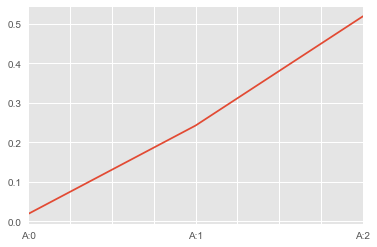

In [146]:
(pagedemouser['conv']/pagedemo['page_demo_cat'].value_counts()).plot()

#### name_request_demo : the frequency of request for demo 

In [88]:
request_demo = pd.DataFrame(df[['properties.name_request_demo','convert']].copy())
request_demo['properties.name_request_demo_cat'] = request_demo['properties.name_request_demo']
request_demo.loc[request_demo['properties.name_request_demo']==0,'properties.name_request_demo_cat']='A:0'
request_demo.loc[request_demo['properties.name_request_demo']==1,'properties.name_request_demo_cat']='A:1'
request_demo.loc[request_demo['properties.name_request_demo']>=2,'properties.name_request_demo_cat']='A:2'

In [92]:
request_demo_user = request_demo.groupby('properties.name_request_demo_cat')['convert'].value_counts().unstack().fillna(0)
request_demo_user.columns = ['nonconv','conv']
request_demo_user['conv']/request_demo['properties.name_request_demo_cat'].value_counts()

properties.name_request_demo_cat
A:0    0.016781
A:1    0.139189
A:2    0.458333
dtype: float64

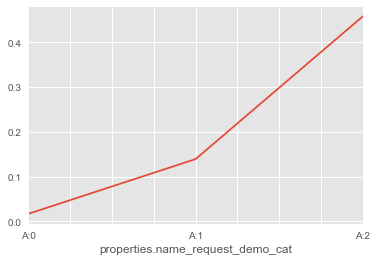

In [93]:
(request_demo_user['conv']/request_demo['properties.name_request_demo_cat'].value_counts()).plot()

#### Time_duration: totoal time spent per user(unit:MS)

In [125]:
Timeuser = pd.DataFrame(df[['time_durationByMS','convert']].copy())

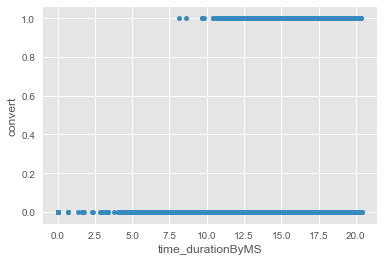

In [126]:
Timeuser.plot('time_durationByMS','convert',kind='scatter')

In [133]:
Timeuser['time_cat'] =  Timeuser['time_durationByMS']
Timeuser.loc[Timeuser['time_durationByMS']<=7.5,'time_cat'] = 'A:7.5'
Timeuser.loc[(Timeuser['time_durationByMS']>7.5) & (Timeuser['time_durationByMS']<=15),'time_cat'] = 'A:7.5 - 15'
Timeuser.loc[Timeuser['time_durationByMS']>15,'time_cat']='A:g15'

In [134]:
Timeuser['time_cat'].value_counts()

A:7.5 - 15    6051
A:7.5         3581
A:g15         2124
Name: time_cat, dtype: int64

In [135]:
timeuser = Timeuser.groupby('time_cat')['convert'].value_counts().unstack().fillna(0)
timeuser.columns = ['nonconv','conv']

In [136]:
timeuser['conv']/Timeuser['time_cat'].value_counts()

A:7.5         0.000000
A:7.5 - 15    0.051727
A:g15         0.097928
dtype: float64

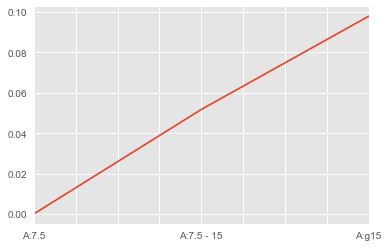

In [137]:
(timeuser['conv']/Timeuser['time_cat'].value_counts()).plot()

* Mobile users conversion rate is much lower than computer user 
* Beijing and Guangdong users conversion rate are slightly above Chinese users conversion rate.
* Chrome and Firefox users have higher conversion rate than other safari and other brower users.

In [332]:
funnel_cols = ['properties.$os_cat_Android','properties.$os_cat_iOS', 'properties.$os_cat_linux',\
               'properties.$os_cat_macosx', 'properties.$os_cat_windows', 'properties.$model_cat_mac',\
               'properties.$model_cat_other','properties.$model_cat_pc',\
                'properties.$ip_Beijing', 'properties.$ip_Guangdong',
       'properties.$ip_Shanghai', 'properties.$ip_Zhejiang',
       'properties.$ip_China', 'properties.$browser_cat_chrome',
       'properties.$browser_cat_firefox', 'properties.$browser_cat_other',
       'properties.$browser_cat_safari',
       'properties.$first_browser_language0_en',
       'properties.$first_browser_language0_other',
       'properties.$first_browser_language0_zh']

for i in funnel_cols:
    temp = df.groupby(i)['convert'].value_counts().unstack().fillna(0)
    print (i)
    print (temp.iloc[1,1]/(temp.iloc[1,].sum()))

properties.$os_cat_Android
0.0171379605827
properties.$os_cat_iOS
0.0168067226891
properties.$os_cat_linux
0.0
properties.$os_cat_macosx
0.0577565632458
properties.$os_cat_windows
0.0502435629784
properties.$model_cat_mac
0.0577565632458
properties.$model_cat_other
0.0170068027211
properties.$model_cat_pc
0.0502435629784
properties.$ip_Beijing
0.0453738910013
properties.$ip_Guangdong
0.0487903225806
properties.$ip_Shanghai
0.0432276657061
properties.$ip_Zhejiang
0.0398803589232
properties.$ip_China
0.045079086116
properties.$browser_cat_chrome
0.0518745218057
properties.$browser_cat_firefox
0.0552845528455
properties.$browser_cat_other
0.0318374772589
properties.$browser_cat_safari
0.034126984127
properties.$first_browser_language0_en
0.0140186915888
properties.$first_browser_language0_other
0.0
properties.$first_browser_language0_zh
0.0504847481674


In [331]:
funnel_cols2 = ['properties.$latest_referrer_host_cat_content',
       'properties.$latest_referrer_host_cat_other',
       'properties.$latest_referrer_host_cat_search',
       'properties.$latest_referrer_host_cat_sensors',
       'properties.$latest_utm_source_cat_content',
       'properties.$latest_utm_source_cat_other',
       'properties.$latest_utm_source_cat_search',
       'properties.$latest_utm_source_cat_social',
       'properties.$latest_utm_campaign_cat_other',
       'properties.$latest_utm_campaign_cat_品牌词',
       'properties.$latest_utm_campaign_cat_神策-移动推广',
       'properties.$latest_utm_campaign_cat_通用词',
       'properties.$latest_utm_medium_cat_cpc',
       'properties.$latest_utm_medium_cat_mcpc',
       'properties.$latest_utm_medium_cat_mfeed',
       'properties.$latest_utm_medium_cat_other',
       'properties.$latest_utm_content_cat_品牌',
       'properties.$latest_utm_content_cat_通用']

for i in funnel_cols2:
    temp = df.groupby(i)['convert'].value_counts().unstack().fillna(0)
    print (i)
    print (temp.iloc[1,1]/(temp.iloc[1,].sum()))   

properties.$latest_referrer_host_cat_content
0.013986013986
properties.$latest_referrer_host_cat_other
0.0
properties.$latest_referrer_host_cat_search
0.00162337662338
properties.$latest_referrer_host_cat_sensors
0.0
properties.$latest_utm_source_cat_content
0.0
properties.$latest_utm_source_cat_other
0.05
properties.$latest_utm_source_cat_search
0.0
properties.$latest_utm_source_cat_social
0.0
properties.$latest_utm_campaign_cat_other
0.00237529691211
properties.$latest_utm_campaign_cat_品牌词
0.0
properties.$latest_utm_campaign_cat_神策-移动推广
0.0
properties.$latest_utm_campaign_cat_通用词
0.0
properties.$latest_utm_medium_cat_cpc
0.0
properties.$latest_utm_medium_cat_mcpc
0.0
properties.$latest_utm_medium_cat_mfeed
0.0
properties.$latest_utm_medium_cat_other
0.0666666666667
properties.$latest_utm_content_cat_品牌
0.0
properties.$latest_utm_content_cat_通用
0.0
